# Ficha de trabalho 3

1 - Considera o dataset cachexia. Lê os dados usando a função read_csv do pandas (dados e metadados).

In [1]:
from pandas import read_csv

data = read_csv('data_cachexia.csv', sep = ',', index_col = 0)
print(data)

              1.6-Anhydro-beta-D-glucose  1-Methylnicotinamide  \
Patient ID                                                       
PIF_178                            40.85                 65.37   
PIF_087                            62.18                340.36   
PIF_090                           270.43                 64.72   
NETL_005_V1                       154.47                 52.98   
PIF_115                            22.20                 73.70   
...                                  ...                   ...   
NETCR_019_V2                       35.16                 52.46   
NETL_012_V1                        16.95                 15.80   
NETL_012_V2                         9.39                 14.01   
NETL_003_V1                        37.71                 18.17   
NETL_003_V2                        38.47                 12.55   

              2-Aminobutyrate  2-Hydroxyisobutyrate  2-Oxoglutarate  \
Patient ID                                                            

In [2]:
meta = read_csv('meta_cachexia.csv', sep = ',', index_col = 0)
print(meta)

             Muscle.loss
sample                  
PIF_178         cachexic
PIF_087         cachexic
PIF_090         cachexic
NETL_005_V1     cachexic
PIF_115         cachexic
...                  ...
NETCR_019_V2     control
NETL_012_V1      control
NETL_012_V2      control
NETL_003_V1      control
NETL_003_V2      control

[77 rows x 1 columns]


2 - Aplica a transformação necessária para que os dados seja escalonados para ter média 0 e desvio padrão 1. Verifica que as médias de todas as colunas é aproximadamente zero.

In [3]:
from sklearn import preprocessing

input_data = data.values
output_data = meta.values[:,0]

input_scaled = preprocessing.scale(input_data)

print("Global Mean:", input_scaled.mean())
print("Global Standard Deviation:", input_scaled.std())

meanValidation = ((input_scaled.mean(axis = 0) < 0.000001) & (input_scaled.mean(axis = 0) > -0.000001)).all()

print('\nThe averages for all columns are approximately zero?', meanValidation)

Global Mean: -1.8675365658506033e-17
Global Standard Deviation: 1.0

The averages for all columns are approximately zero? True


3 - Cria conjuntos de dados treino e teste para serem usados na criação e validação de modelos de aprendizagem máquina. Considera 30% das amostras para formar o conjunto de teste. 

In [4]:
from sklearn.model_selection import train_test_split

train_in, test_in, train_out, test_out = train_test_split(input_scaled, output_data, test_size = 0.3)

print('Samples dimensions:\n')
print('Train (input):', train_in.shape)
print('Test (input):', test_in.shape)
print('Train (output):', train_out.shape)
print('Test (output):', test_out.shape)

Samples dimensions:

Train (input): (53, 63)
Test (input): (24, 63)
Train (output): (53,)
Test (output): (24,)


4 - Constroi diversos tipos de modelos de classificação treinando e testando com os conjuntos criados anteriormente. Calcula, para cada um dos modelos no test set, as métricas de erro PECC e F1-score, e calcula a matriz de confusão. Considere como classe positiva a classe "cachexic"

In [5]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt

labels = ['cachexic', 'control']

def showConfusionMatrix(cm):
    tn, fp, fn, tp = cm.ravel()
    matrix = [[tp, fp], [fn, tn]]
    fig, ax = plt.subplots(1,1)
    fig.suptitle('Confusion Matrix', fontsize = 20)
    plt.axis('off')
    ax.table(cellText = matrix, rowLabels = labels, colLabels = labels, loc = 'center', 
             cellLoc = 'center')

PECC: 0.6666666666666666
F1-score: 0.7333333333333334


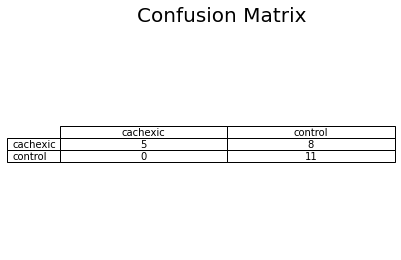

In [6]:
# K-Nearest Neighbors

from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier()
knn_model.fit(train_in, train_out)
prediction = knn_model.predict(test_in)

print('PECC:', accuracy_score(prediction, test_out))
print('F1-score:', f1_score(test_out, prediction, pos_label = 'cachexic'))
cm = confusion_matrix(test_out, prediction)
showConfusionMatrix(cm)

PECC: 0.5833333333333334
F1-score: 0.6428571428571429


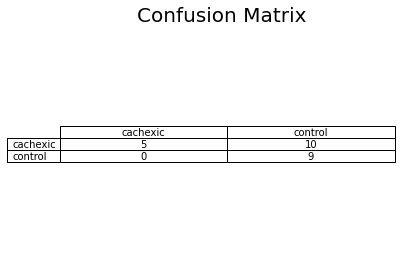

In [7]:
# Logistic Regression

from sklearn import linear_model

lr_model = linear_model.LogisticRegression(solver = 'liblinear', multi_class = 'auto')
lr_model.fit(train_in, train_out)
prediction = lr_model.predict(test_in)

print('PECC:', accuracy_score(prediction, test_out))
print('F1-score:', f1_score(test_out, prediction, pos_label = 'cachexic'))
cm = confusion_matrix(test_out, prediction)
showConfusionMatrix(cm)

PECC: 0.75
F1-score: 0.8125000000000001


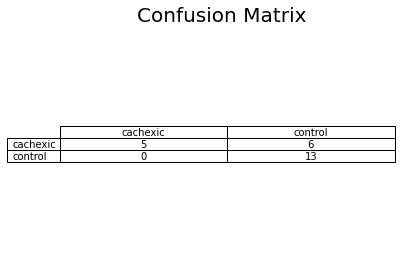

In [8]:
# Support Vector Machines

from sklearn import svm

svm_model = svm.SVC(gamma = 'scale')
svm_model.fit(train_in, train_out)
prediction = svm_model.predict(test_in)

print('PECC:', accuracy_score(prediction, test_out))
print('F1-score:', f1_score(test_out, prediction, pos_label = 'cachexic'))
cm = confusion_matrix(test_out, prediction)
showConfusionMatrix(cm)

5 ~ Usando os 2 modelos anteriores que lhe parecerem mais promissores avalie-os usando validação cruzada. O que conclui do desempenho dos modelos ?

In [9]:
from sklearn.model_selection import cross_val_score

# KNN
knn_cv = cross_val_score(knn_model, input_scaled, output_data, cv = 5)
print('Cross Validation Score for KNN:', knn_cv.mean())

# SVM
svm_cv = cross_val_score(svm_model, input_scaled, output_data, cv = 5)
print('Cross Validation Score for SVM:', svm_cv.mean())

Cross Validation Score for KNN: 0.6516666666666667
Cross Validation Score for SVM: 0.7283333333333333


6 - Usando apenas o melhor modelo do exercício anterior, compare o seu desempenho considerando: i) os dados originais; ii) os dados standardizados criados no ex. 2; iii) dados com transformação logaritmica e posteriomente standardizados

In [10]:
import numpy as np

# Original data
svm_cv_original = cross_val_score(knn_model, input_data, output_data, cv = 5)
print('Original data\n')
print('> Cross validation score:', svm_cv_original.mean())
print('\n---\n')

# Standardized data
svm_cv_stadardized = cross_val_score(knn_model, input_scaled, output_data, cv = 5)
print('Standardized Data\n')
print('> Cross validation score:', svm_cv_stadardized.mean())
print('\n---\n')

# Data with logarithmic transformation
input_log = np.log2(input_data)
svm_cv_log = cross_val_score(knn_model, input_log, output_data, cv = 5)
print('Data with logarithmic transformation\n')
print('> Cross validation score:', svm_cv_log.mean())
print('\n---\n')

# Data with standardized logarithmic transformation
input_log_scaled = preprocessing.scale(input_log)
svm_cv_log_scaled = cross_val_score(knn_model, input_log_scaled, output_data, cv = 5)
print('Data with standardized logarithmic transformation\n')
print('> Cross validation score:', svm_cv_log_scaled.mean())

Original data

> Cross validation score: 0.5974999999999999

---

Standardized Data

> Cross validation score: 0.6516666666666667

---

Data with logarithmic transformation

> Cross validation score: 0.755

---

Data with standardized logarithmic transformation

> Cross validation score: 0.6766666666666667


7 - Procure o melhor valor para os parâmetros C e gamma no modelo SVM, usando o dataset que tenha funcionado melhor em 6.

In [11]:
from sklearn.model_selection import GridSearchCV

# Dictionary of possible parameters
parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.0001, 0.001, 0.01, 0.1],
              'kernel': ['linear','rbf']}

grid = GridSearchCV(svm_model, parameters)
grid.fit(input_log_scaled, output_data)
print('The best parameters are %s with a score of %s' % (grid.best_estimator_, grid.best_score_))

The best parameters are SVC(C=0.01, gamma=0.0001, kernel='linear') with a score of 0.7283333333333333
